# Introduction to crispy

This software is designed to simulate lenslet array-based Integral Field Spectrographs and their reduction process. This was developed within the context of NASA's WFIRST Coronagraph mission.

In this notebook we go straight to the point and illustrate how to use the code. We require astropy, numpy. This notebook was written in a Python 3.5 kernel but should be backward compatible with Python 2.7.

## Create a polychromatic flatfield

### Initialization

First we need to load the various modules that we need. Since the notebook can be located anywhere, we need to add the location of the Python code to the path first.

In [1]:
import sys
codefolder = '../../../../crispy'
if codefolder not in sys.path: sys.path.append(codefolder)
import glob
import numpy as np
from crispy.tools.initLogger import getLogger
log = getLogger('crispy')

All the IFS parameters are contained within a Python class called 'Params'. This class is initialized using only the path the 'code' directory from the repo. In particular, the Params class stores all the relevant paths. All parameters can be changed on the fly.

In [2]:
from crispy.params import Params
codefolder = '../../../crispy'
par = Params(codefolder)

All the parameters are stored in this class. During the various steps of the software, they are appended to a header file.

In [3]:
par.hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
COMMENT                                                                         
COMMENT ************************************************************            
COMMENT ********************** General parameters ******************            
COMMENT ************************************************************            
COMMENT                                                                         
NLENS   =                  108 / # lenslets across array                        
PITCH   =             0.000174 / Lenslet pitch (meters)                         
INTERLAC=                    2 / Interlacing                                    
PHILENS =    26.565051177077

### Create the flatfield

Creating a flatfield is a function built into the unitTests module. In this case, we will construct a cube of nlam wavelength slices, each having 512x512 pixels of value 1. The standard 

In [4]:
from crispy.unitTests import testCreateFlatfield
help(testCreateFlatfield)

Help on function testCreateFlatfield in module crispy.unitTests:

testCreateFlatfield(par, pixsize=0.1, npix=512, pixval=1.0, outname='flatfield.fits')
    Creates a polychromatic flatfield
    
    Parameters
    ----------
    par :   Parameter instance
        Contains all IFS parameters
    pixsize:   float
       Pixel scale (lam/D)
    npix: int
        Each input frame has a pixel size npix x npix
    pixval: float
        Each input frame has a unform value pixval



This test function will create a polychromatic flatfield at the wavelengths provided by the existing wavelength calibration. Those wavelengths can be retrieved as follows.

In [5]:
from crispy.tools.reduction import calculateWaveList
help(calculateWaveList)
lam_midpts,lam_endpts = calculateWaveList(par)
print(lam_midpts)

Help on function calculateWaveList in module crispy.tools.reduction:

calculateWaveList(par, lam_list=None)
    Computes the wavelength lists corresponding to the center and endpoints of each
    spectral bin. Wavelengths are separated by a constant value in log space. Number of
    wavelengths depends on spectral resolution.
    
    Parameters
    ----------
    par:        Parameter instance
            Contains all IFS parameters
    lam_list:   list of wavelengths
            Usually this is left to None. If so, we use the wavelengths used for wavelength
            calibration. Otherwise, we could decide to focus on a smaller/larger region of
            the spectrum to retrieve. The final processed cubes will have bins centered
            on lam_midpts
            
    Returns
    -------
    lam_midpts: list of floats
            Wavelengths at the midpoint of each bin
    lam_endpts: list of floats
            Wavelengths at the edges of each bin

crispy - INFO - Reduced cube

Now let's create our flatfield. By default it will be stored as par.unitTestsOutput/flatfield.fits

In [9]:
testCreateFlatfield(par)

crispy - INFO - Reduced cube will have 17 wavelength bins
crispy - INFO - The number of input pixels per lenslet is 4.303178
crispy - INFO - Using PSFlet gaussian approximation
crispy - INFO - Final detector pixel per PSFLet: 40.000000
crispy - INFO - Processing wavelength 0.704430 (0 out of 17)
crispy - INFO - Processing wavelength 0.711948 (1 out of 17)
crispy - INFO - Processing wavelength 0.719547 (2 out of 17)
crispy - INFO - Processing wavelength 0.727227 (3 out of 17)
crispy - INFO - Processing wavelength 0.734989 (4 out of 17)
crispy - INFO - Processing wavelength 0.742834 (5 out of 17)
crispy - INFO - Processing wavelength 0.750763 (6 out of 17)
crispy - INFO - Processing wavelength 0.758776 (7 out of 17)
crispy - INFO - Processing wavelength 0.766875 (8 out of 17)
crispy - INFO - Processing wavelength 0.775060 (9 out of 17)
crispy - INFO - Processing wavelength 0.783333 (10 out of 17)
crispy - INFO - Processing wavelength 0.791694 (11 out of 17)
crispy - INFO - Processing wav

### Display results

Depending on your version of Python you might see a bunch of VisibleDeprecationWarning. We are working on fixing that. Let's see what we got.

In [10]:
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest'

Populating the interactive namespace from numpy and matplotlib


crispy - INFO - Read data from HDU 1 of ../../../crispy/unitTestsOutputs/flatfield.fits


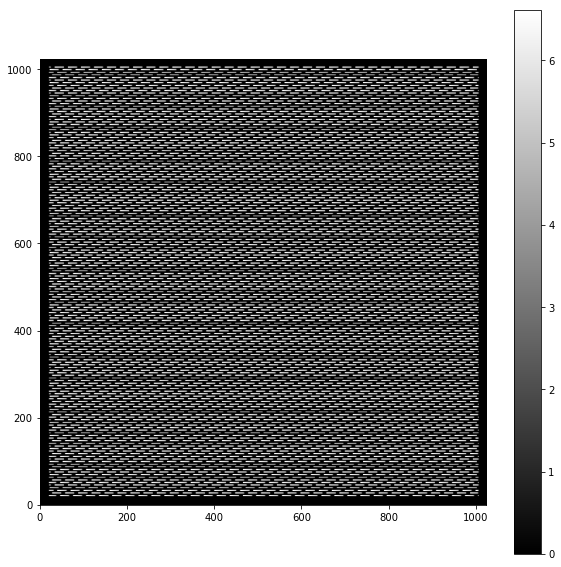

In [11]:
from crispy.tools.image import Image
plt.figure(figsize=(10,10))
plt.imshow(Image(par.unitTestsOutputs+'/flatfield.fits').data,cmap='gray')
plt.colorbar()

A zoom-in version is visible here:

crispy - INFO - Read data from HDU 1 of ../../../crispy/unitTestsOutputs/flatfield.fits


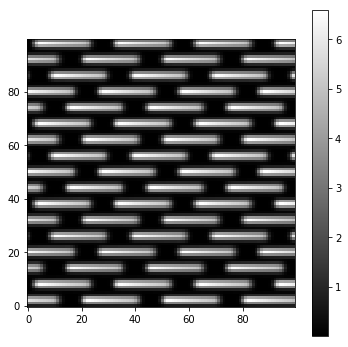

In [12]:
plt.figure(figsize=(6,6))
img = Image(par.unitTestsOutputs+'/flatfield.fits').data
subsize = 50
plt.imshow(img[par.npix//2-subsize:par.npix//2+subsize,par.npix//2-subsize:par.npix//2+subsize],cmap='gray')
plt.colorbar()

## Simulate detector readout

We have also some routines that can add noise to the detector. Assuming that the input detector map is in photons per second, we can 'detectorify' this map by adding Poisson noise, read noise, CIC noise, and dark current noise. In the future, we will also implement Electron-multiplying noise and Traps.

In [13]:
from crispy.tools.image import Image
from crispy.tools.detector import readDetector,averageDetectorReadout
flat = Image(filename=par.unitTestsOutputs+'/flatfield.fits')
read=readDetector(par,flat,inttime=100,append_header=True)


crispy - INFO - Read data from HDU 1 of ../../../crispy/unitTestsOutputs/flatfield.fits


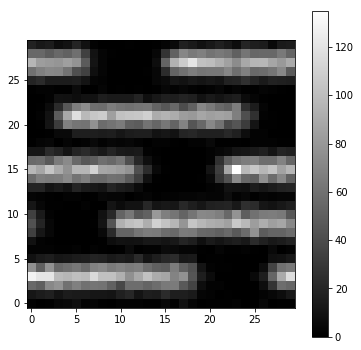

In [14]:
plt.figure(figsize=(6,6))
subsize = 15
plt.imshow(read[par.npix//2-subsize:par.npix//2+subsize,par.npix//2-subsize:par.npix//2+subsize],cmap='gray')
plt.colorbar()

Let's save the noisified frame to a new name. This is useful to show since writing to FITS is a very common task.

In [15]:
newImage = Image(data=read,header=par.hdr)
newImage.write(par.unitTestsOutputs+'/flatfield_noise.fits',clobber=True)


crispy - INFO - Writing data to ../../../crispy/unitTestsOutputs/flatfield_noise.fits


## Reduction step

The reduction step is straightforward, as long as the wavelength calibration is good.

In [17]:
from crispy.IFS import reduceIFSMap
cube = reduceIFSMap(par,par.unitTestsOutputs+'/flatfield_noise.fits')


crispy - INFO - Read data from HDU 1 of ../../../crispy/unitTestsOutputs/flatfield_noise.fits
crispy - INFO - Reduced cube will have 17 wavelength bins
crispy - INFO - Writing data to ../../../crispy/SimResults/flatfield_noise_red_optext.fits
crispy - INFO - Elapsed time: 12.199787s


Now we can display the cube interactively, or look it up with DS9 (it is located in par.exportDir)

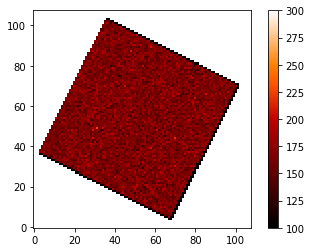

In [20]:
import ipywidgets
def plt_ifs_optext(wchan):
    plt.imshow(cube.data[wchan-1,:,:],
               vmin=100, vmax=300, cmap='gist_heat')
    plt.colorbar()
ipywidgets.interact(plt_ifs_optext, wchan=(1,cube.data.shape[0]));


Let's look now at the header of the created file

In [21]:
cube.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
COMMENT                                                                         
COMMENT ************************************************************            
COMMENT ********************** General parameters ******************            
COMMENT ************************************************************            
COMMENT                                                                         
NLENS   =                  108 / # lenslets across array                        
PITCH   =             0.000174 / Lenslet pitch (meters)                         
INTERLAC=                    2 / Interlacing                                    
PHILENS =    26.565051177077